# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import numpy.polynomial.polynomial as poly
import cv2

%matplotlib inline

## Read in first Images

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


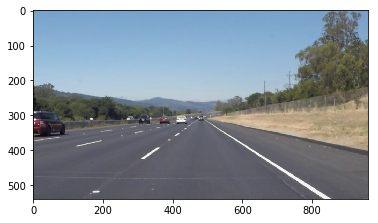

In [2]:
#Read in first image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#Save size of original picture
y_size = image.shape[0]
x_size = image.shape[1]

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    #returns image in grayscale
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def gaussian_blur(img, kernel_size):
    #applies a Gaussian Noise kernel
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    
def canny(img, low_threshold, high_threshold):
    #applies the Canny transform
    return cv2.Canny(img, low_threshold, high_threshold)

def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, original_image, rho, theta, threshold, min_line_len, max_line_gap):        
    #calculate lines/points according to parameters
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #create empty image
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw lines into new image
    draw_lines(line_img, lines, [255, 0, 0], 2)
    #returns an image with hough lines drawn.
    return weighted_img(line_img, original_image), lines

def draw_lines(img, lines, color, thickness):
    #Draws lines with color and thickness into the image
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def average_lines(img, lines, horizon):
    
    #Create lists for all detected line points
    x_array_left=[]
    y_array_left=[]
    x_array_right=[]
    y_array_right=[]
    
    #Go through all detected lines
    for line in lines:
        for x1,y1,x2,y2 in line:
            #Remove horizontal lines
            if ((y2-y1) / (x2-x1)) > 0.3 or ((y2-y1) / (x2-x1)) < -0.3:
                #Save all points depending on slope and location in the picture
                if ((y2-y1) / (x2-x1)) < 0 and x1 < 0.6*x_size and x2 < 0.6*x_size:
                    x_array_left.extend((x1, x2))
                    y_array_left.extend((y1,y2))
                if ((y2-y1) / (x2-x1)) > 0 and x1 > 0.4*x_size and x2 > 0.4*x_size:
                    x_array_right.extend((x1, x2))
                    y_array_right.extend((y1, y2))
    
    #Plot points for visualization
    plt.scatter(x_array_left, y_array_left, s=6, c='red')
    plt.scatter(x_array_right, y_array_right, s=6, c='blue')
    
    #Calculate Coefficients for linear fit for points on both side
    coefs_left_line = poly.polyfit(x_array_left, y_array_left, 1)
    coefs_right_line = poly.polyfit(x_array_right, y_array_right, 1)
    
    #Calculate start and end points for left line / extrapolating
    y_start_left = int(y_size) 
    x_start_left = int((y_start_left - coefs_left_line[0])/coefs_left_line[1])
    y_end_left = int(horizon)
    x_end_left = int((y_end_left - coefs_left_line[0])/coefs_left_line[1])
    
    #Calculate start and end points for right line / extrapolating
    y_start_right = int(horizon) 
    x_start_right = int((y_start_right - coefs_right_line[0])/coefs_right_line[1])
    y_end_right = int(y_size)
    x_end_right = int((y_end_right - coefs_right_line[0])/coefs_right_line[1])
    
    #draw extrapolated line on both sides in new image
    green_lines = np.zeros((y_size, x_size, 3), dtype=np.uint8)
    cv2.line(green_lines, (x_start_left, y_start_left), (x_end_left, y_end_left), [0, 255, 0], 15)
    cv2.line(green_lines, (x_start_right, y_start_right), (x_end_right, y_end_right), [0, 255, 0], 15)
    
    #Return combination with original picture with semi transparent lines   
    return weighted_img(green_lines, img)
    
def weighted_img(img, initial_img, α=0.95, β=1., λ=0.):
    #combination of original picture with semi transparent lines
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
#os.listdir("test_images/")



## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

Original Image:


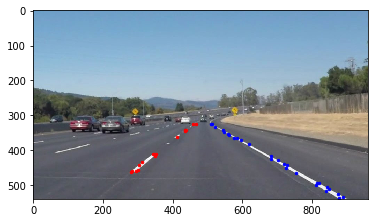

Masked Hough Lines:


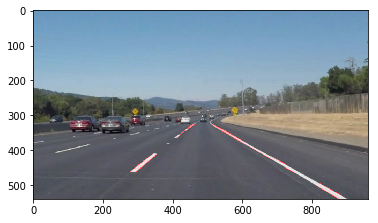

Final Image:


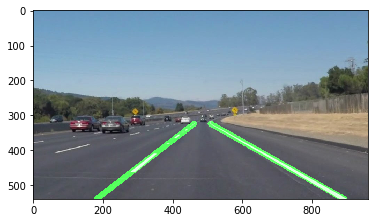

Original Image:


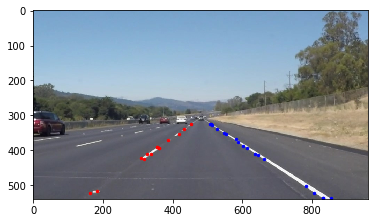

Masked Hough Lines:


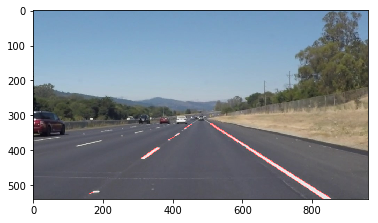

Final Image:


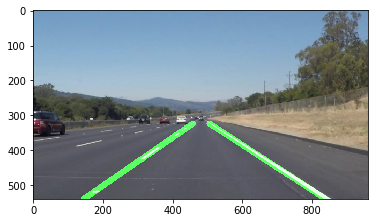

Original Image:


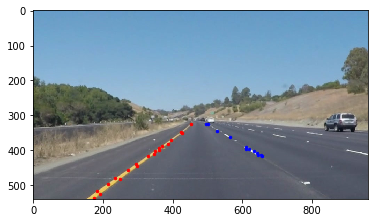

Masked Hough Lines:


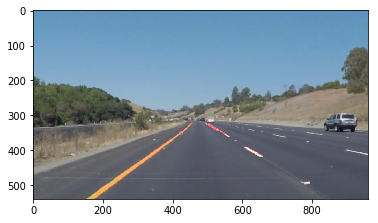

Final Image:


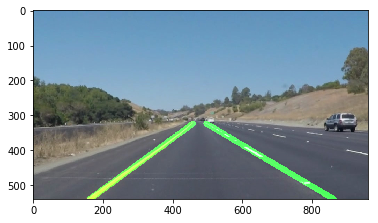

Original Image:


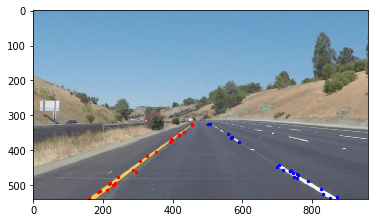

Masked Hough Lines:


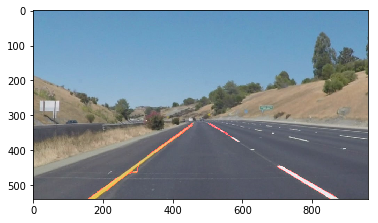

Final Image:


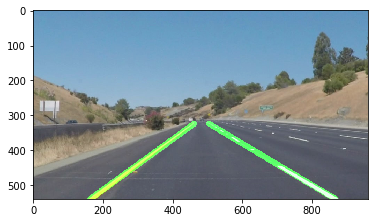

Original Image:


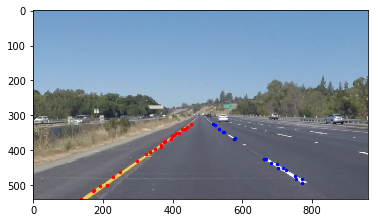

Masked Hough Lines:


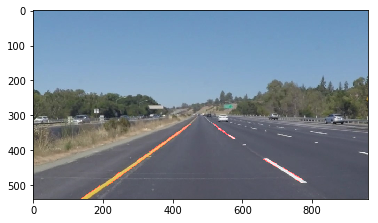

Final Image:


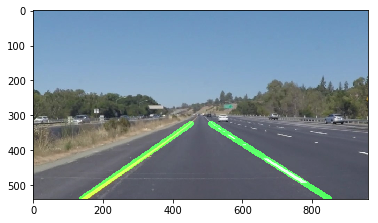

Original Image:


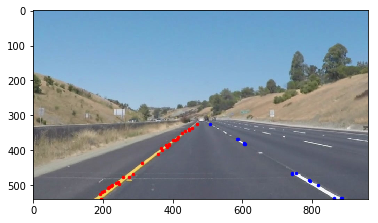

Masked Hough Lines:


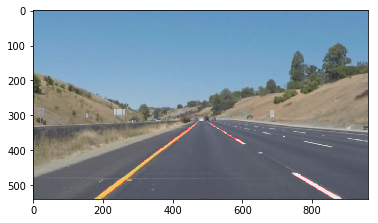

Final Image:


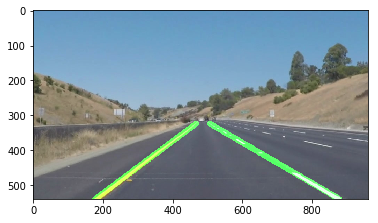

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

for image_file in os.listdir("test_images/"):
    image = mpimg.imread("test_images/" + image_file)
    
    #Save size of original picture
    y_size = image.shape[0]
    x_size = image.shape[1]
   
    """
    # Make a copie of the image that was read in
    color_select = np.copy(image)
    # Define our color selection criteria
    red_threshold = 200
    green_threshold = 200
    blue_threshold = 200
    rgb_threshold = [red_threshold, green_threshold, blue_threshold]
    # Identify pixels below the threshold
    thresholds = (image[:,:,0] < rgb_threshold[0]) \
               | (image[:,:,1] < rgb_threshold[1]) \
               | (image[:,:,2] < rgb_threshold[2])
    color_select[thresholds] = [0,0,0]
    """
    
    #Create Grayscale of original image
    gray = grayscale(image)

    #Apply Gaussian Blur
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    #Apply Canny Edge Detection
    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    
    #Mask the picture
    horizon = 0.60*y_size
    vertices = np.array([[0.12*x_size, y_size],[0.46*x_size, horizon],[0.54*x_size, horizon],[0.95*x_size, y_size]], np.int32)
    #Create masked image
    masked_image = region_of_interest(image, [vertices])
    masked_edges = region_of_interest(edges, [vertices])
    
    #Hough Lines
    rho = 5              # distance resolution in pixels of the Hough grid
    theta = np.pi/180    # angular resolution in radians of the Hough grid
    threshold = 5       # minimum number of votes (intersections in Hough grid cell)
    min_line_len =20     # minimum number of pixels making up a line
    max_line_gap = 15    # maximum gap in pixels between connectable line segments
    masked_hough, lines = hough_lines(masked_edges, image, rho, theta, threshold, min_line_len, max_line_gap)
    
    #Reduce to two solid lines
    image_copy = np.copy(image)
    final_image = average_lines(image_copy, lines, horizon)

    #Save new images
    #mpimg.imsave("test_images/" + image_file[:-4] + "_new.jpg", all_lines)
    
    # Display the images
    print ("Original Image:")
    plt.imshow(image)
    plt.show()
    """
    print ("Masked Image:")
    plt.imshow(masked_image)
    plt.show()
    print ("After Color Selection:")
    plt.imshow(color_select)
    plt.show()
    print ("Grayscale Image:")
    plt.imshow(gray, cmap='gray')
    plt.show()
    print ("Gaussian Blur:")
    plt.imshow(blur_gray, cmap='gray')
    plt.show()
    print ("Canny Edge Detection:")
    plt.imshow(edges, cmap='Greys_r')
    plt.show()
    print ("Masked Canny Edge Detection:")
    plt.imshow(masked_edges, cmap='Greys_r')
    plt.show()
    """
    print ("Masked Hough Lines:")
    plt.imshow(masked_hough)
    plt.show()
    print ("Final Image:")
    plt.imshow(final_image)
    plt.show()


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import * #VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    #Save size of original picture
    y_size = image.shape[0]
    x_size = image.shape[1]
    
    # Create a mask for a region
    horizon = 0.60*y_size
    vertices = np.array([[0.13*x_size, y_size],[0.46*x_size, horizon],[0.54*x_size, horizon],[0.95*x_size, y_size]], np.int32)
    #Create masked image
    masked_image = region_of_interest(image, [vertices])
    
    #Create Grayscale of original image
    gray = grayscale(image)
    
    #Apply Gaussian Blur
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)
    
    #Apply Canny Edge Detection
    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(gray, low_threshold, high_threshold)
    
    #Mask the picture
    masked_edges = region_of_interest(edges, [vertices])
    
    #Hough Lines
    rho = 5             # distance resolution in pixels of the Hough grid
    theta = np.pi/180   # angular resolution in radians of the Hough grid
    threshold = 10      # minimum number of votes (intersections in Hough grid cell)
    min_line_len =25    # minimum number of pixels making up a line
    max_line_gap = 10   # maximum gap in pixels between connectable line segments
    masked_hough, lines = hough_lines(masked_edges, image, rho, theta, threshold, min_line_len, max_line_gap)
    
    #Reduce to two solid lines
    image_copy = np.copy(image)
    final_image = average_lines(image_copy, lines, horizon)
    
    return final_image

Let's try the one with the solid white lane on the right first ...

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:08<00:00, 22.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 9.47 s


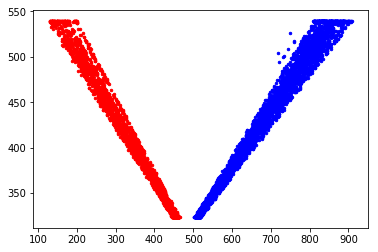

In [8]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML(""" <video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:23<00:00, 28.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 24.7 s


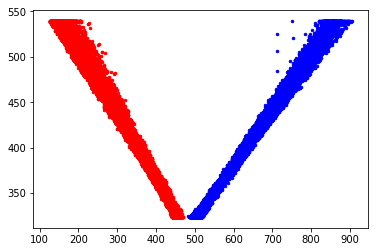

In [10]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

error: ..\..\..\modules\core\src\arithm.cpp:639: error: (-209) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function cv::arithm_op


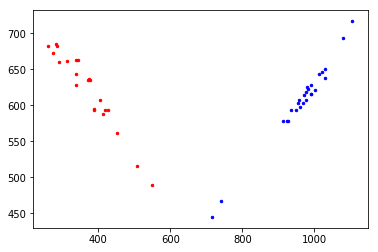

In [12]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))